Ejemplos queries FS2 de cosmohub

- lenses 

```SQL
SELECT `halo_id`, `ra_gal`, `dec_gal`, `ra_mag_gal`, `dec_mag_gal`, `true_redshift_gal`, `observed_redshift_gal`
FROM fs2_mock_std_2_1_10b_phz_wise 
WHERE `lm_halo` >14 and lm_halo < 14.5 and true_redshift_gal > 0.25 and true_redshift_gal < 0.35 and kind == 0
```

- sources
```SQL
SELECT `ra_gal`, `dec_gal`, `ra_mag_gal`, `dec_mag_gal`, `true_redshift_gal`, `observed_redshift_gal`, `gamma1`, `gamma2` 
FROM fs2_mock_std_2_1_10b_phz_wise
WHERE `lm_halo` >14 and lm_halo < 14.5 and true_redshift_gal > 0.5 and true_redshift_gal < 0.8
```

In [1]:
import sys
import os
import numpy as np
import pandas as pd
from astropy.cosmology import LambdaCDM
import matplotlib.pyplot as plt
import time as time
# sys.path.append('/nfs/pic.es/user/e/egonzale/ia_cal/IACorr')
from compute_IA_corr_from_data import compute_2p_corr
cosmology = LambdaCDM(H0=100.0, Om0=0.3089, Ode0=0.6911)

In [62]:
import treecorr

In [2]:
sys.path.append('/home/fcaporaso/modified_gravity/')
from lensing.funcs import lenscat_load

In [3]:
from astropy.io import fits

In [4]:
def d_com(z):
    return cosmology.comoving_distance(z).value

In [5]:
def make_randoms(ra, dec, redshift,
                 size_random = 100):
    
    print('Making randoms...')
    np.random.seed(1)
    
    dec = np.deg2rad(dec)
    sindec_rand = np.random.uniform(np.sin(dec.min()), np.sin(dec.max()), size_random)
    dec_rand = np.arcsin(sindec_rand)*(180/np.pi)
    ra_rand  = np.random.uniform(ra.min(), ra.max(), size_random)

    y,xbins  = np.histogram(redshift, 25)
    x  = xbins[:-1]+0.5*np.diff(xbins)
    n = 3
    poly = np.polyfit(x,y,n)
    zr = np.random.uniform(redshift.min(),redshift.max(),size_random)
    poly_y = np.poly1d(poly)(zr)
    poly_y[poly_y<0] = 0.
    peso = poly_y/sum(poly_y)
    z_rand = np.random.choice(zr,size_random,replace=True,p=peso)

    print('Wii randoms!')
    return pd.DataFrame({'ra': ra_rand, 'dec': dec_rand, 'redshift':z_rand})


In [6]:
path = '/home/fcaporaso/cats/L768/'

In [7]:
Rv_min, Rv_max, z_min, z_max, rho1_min, rho1_max, rho2_min, rho2_max, flag = 22.0,50.0,0.2,0.3,-1.0,0.0,-1.0,100.0,2.0
ncores, nk = 1,1

In [8]:
lenses = pd.DataFrame(
    lenscat_load(
        path+'voids_LCDM_09.dat',
        Rv_min, Rv_max, z_min, z_max, rho1_min, rho1_max, rho2_min, rho2_max, flag,ncores,nk
    )[0].T,
    columns=['rv','ra','dec','redshift','xv','yv','zv','rho1','rho2','logp','cmdist','flag']
)

In [36]:
len(lenses)

214

In [10]:
sources = pd.DataFrame(
    fits.open(path+'l768_gr_centrals_19602.fits')[1].data,
)
sources.rename(columns={'ra_gal':'ra','dec_gal':'dec','true_redshift_gal':'redshift'},inplace=True)

In [11]:
sources.head()

,ra,dec,redshift,halo_lm
0,266.795624,-8.432777,0.068933,13.629190
1,224.076447,-33.448631,0.049334,13.538427
2,239.543274,29.744623,0.005805,13.509583
3,200.170044,-19.591839,0.115107,14.108797
4,188.430923,-30.150970,0.084341,13.827502


In [64]:
col_names = ['ra','dec','r_com','gamma1','gamma2', 'weight']
ra,dec,r,e1,e2,w = col_names
redshift = 'redshift'

In [13]:
len(sources)

30948609

In [15]:
random_lenses = make_randoms(lenses[ra],lenses[dec],lenses[redshift], size_random=len(lenses)*2)
random_sources = make_randoms(sources[ra],sources[dec], sources[redshift], size_random=len(sources)*2)

Making randoms...
Wii randoms!
Making randoms...
Wii randoms!


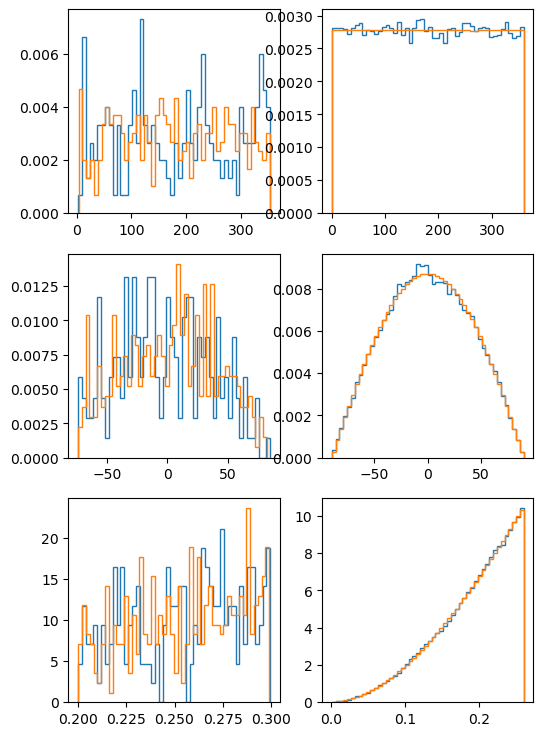

In [16]:
fig, ax = plt.subplots(3,2,
                      figsize=(6,9))

# axL,axS = ax[:,0], ax[:,1]

for j,name in enumerate(['ra','dec','redshift']):

    ax[j,0].hist(lenses[name], histtype='step', bins=50, density=True)
    ax[j,0].hist(random_lenses[name], histtype='step', bins=50, density=True)
    
    ax[j,1].hist(sources[name], histtype='step', bins=50, density=True)
    ax[j,1].hist(random_sources[name], histtype='step', bins=50, density=True)

# ax[-1,-1].legend()
plt.show()

In [17]:
lenses[w] = np.ones(len(lenses))

In [66]:
random_lenses[w] = np.ones(len(random_lenses))
random_sources[w] = np.ones(len(random_sources))

In [18]:
sources[w] = np.ones(len(sources))

In [19]:
lenses[dcom] = cosmology.comoving_distance(lenses[redshift]).value

In [20]:
random_lenses[dcom] = cosmology.comoving_distance(random_lenses[redshift]).value

In [21]:
sources[dcom] = cosmology.comoving_distance(sources[redshift]).value

In [22]:
random_sources[dcom] = cosmology.comoving_distance(random_sources[redshift]).value

In [23]:
## caso VOID-GALAXY solo neceisto posiciones, relleno formas con 1
sources[e1] = np.ones(len(sources))
sources[e2] = np.ones(len(sources))

In [40]:
## caso VOID-GALAXY solo neceisto posiciones, relleno formas con 1
lenses[e1] = np.ones(len(lenses))
lenses[e2] = np.ones(len(lenses))

### Configuration 

In [28]:
# parameters related with bins
nbins = 10 # number of radial bins
rmin = 0.01 # minimum value for rp (r in case of the quadrupole)
rmax = 5.0 # maximum value for rp (r in case of the quadrupole)

rmin*=lenses['rv'].mean()
rmax*=lenses['rv'].mean()

# Related to JK patches
NPatches = int(nbins**(3./2.))
print('Number of patches',NPatches)
# Other configuration parameters
ncores = 2 # Number of cores to run in parallel
slop = 0. # Resolution for treecorr
box = False # Indicates if the data corresponds to a box, otherwise it will assume a lightcone


Number of patches 31


In [29]:
config = {'col_names': col_names,
          'nbins': nbins,
          'rmin': rmin,
          'rmax': rmax,
          'NPatches': NPatches,
          'ncores': ncores,
          'slop': slop,
          'box': box,
         }

In [67]:
dvcat = treecorr.Catalog(
    ra=lenses[ra], 
    dec=lenses[dec], 
    w = lenses[w], 
    r=lenses[r], 
    npatch = config['NPatches'], 
    ra_units='deg', dec_units='deg'
)

dgcat = treecorr.Catalog(
    ra=sources[ra], 
    dec=sources[dec], 
    w = sources[w], 
    r=sources[r], 
    npatch = config['NPatches'], 
    ra_units='deg', dec_units='deg'
)

rvcat = treecorr.Catalog(
    ra=random_lenses[ra], 
    dec=random_lenses[dec], 
    w = random_lenses[w], 
    r=random_lenses[r], 
    npatch = config['NPatches'], 
    ra_units='deg', dec_units='deg'
)

rgcat = treecorr.Catalog(
    ra=random_sources[ra], 
    dec=random_sources[dec], 
    w = random_sources[w], 
    r=random_sources[r], 
    npatch = config['NPatches'], 
    ra_units='deg', dec_units='deg'
)

In [68]:
# arrays to store the output
r     = np.zeros(config['nbins'])
mean_r     = np.zeros(config['nbins'])
mean_logr     = np.zeros(config['nbins'])
xi = np.zeros((config['npi'], config['nbins']))
xi_jk = np.zeros((config['NPatches'], config['npi'], config['nbins']))

dd_jk = np.zeros_like(xi_jk)
dr_jk = np.zeros_like(xi_jk)
rr_jk = np.zeros_like(xi_jk)


# Pair normalization fractions
Ndv = dvcat.sumw
Nrv = rvcat.sumw
Ndg = dgcat.sumw
Nrg = rgcat.sumw
NNpairs = (Nd*(Nd - 1))/2.
RRpairs = (Nr*(Nr - 1))/2.
NRpairs = (rcat.sumw*dcat.sumw)

f0 = RRpairs/NNpairs
f1 = RRpairs/NRpairs

Pi = np.linspace(-1.*config['pi_max'], config['pi_max'], config['npi']+1)
pibins = zip(Pi[:-1],Pi[1:])

# now loop over Pi bins, and compute w(r_p | Pi)
for p,(plow,phigh) in enumerate(pibins):

    dvdr = treecorr.NNCorrelation(
        nbins=config['nbins'], 
        min_sep=config['rmin'], 
        max_sep=config['rmax'], 
        min_rpar=plow, max_rpar=phigh,
        bin_slop=config['slop'], brute = False, 
        verbose=0, var_method = 'jackknife'
    )

    dvrg = treecorr.NNCorrelation(
        nbins=config['nbins'], 
        min_sep=config['rmin'], 
        max_sep=config['rmax'], 
        min_rpar=plow, max_rpar=phigh,
        bin_slop=config['slop'], brute = False, 
        verbose=0, var_method = 'jackknife'
    )
        
    rvdg = treecorr.NNCorrelation(
        nbins=config['nbins'], 
        min_sep=config['rmin'], 
        max_sep=config['rmax'], 
        min_rpar=plow, max_rpar=phigh,
        bin_slop=config['slop'], brute = False, 
        verbose=0, var_method = 'jackknife'
    )

    rvrg = treecorr.NNCorrelation(
        nbins=config['nbins'], 
        min_sep=config['rmin'], 
        max_sep=config['rmax'], 
        min_rpar=plow, max_rpar=phigh,
        bin_slop=config['slop'], brute = False, 
        verbose=0, var_method = 'jackknife'
    )
    
    if config['box']:
        factor = 0.5
        dd.process(dcat,dcat, metric='Rperp', num_threads = config['ncores'])
        rr.process(rcat,rcat, metric='Rperp', num_threads = config['ncores'])
    else:
        factor = 1.0
        dvdg.process(dvcat, dgcat, metric='Rperp', num_threads = config['ncores'])
        dvrg.process(dvcat, rgcat, metric='Rperp', num_threads = config['ncores'])
        rvdg.process(rvcat, dgcat, metric='Rperp', num_threads = config['ncores'])
        rvrg.process(rvcat, rgcat, metric='Rperp', num_threads = config['ncores'])

    dr.process(dcat,rcat, metric='Rperp', num_threads = config['ncores'])

    r[:] = np.copy(dd.rnom)
    mean_r[:] = np.copy(dd.meanr)
    mean_logr[:] = np.copy(dd.meanlogr)

    xi[p, :] = (dd.weight*factor*f0 - (2.*dr.weight)*f1 + rr.weight*factor) / (rr.weight*factor)


    #Here I compute the variance
    func = lambda corrs: corrs[0].weight*factor
    func2 = lambda corrs: corrs[0].weight
    dd_jk[:, p, :], weight = treecorr.build_multi_cov_design_matrix([dd], 'jackknife', func = func)
    dr_jk[:, p, :], weight = treecorr.build_multi_cov_design_matrix([dr], 'jackknife', func = func2)
    rr_jk[:, p, :], weight = treecorr.build_multi_cov_design_matrix([rr], 'jackknife', func = func)

    dd.finalize()
    dr.finalize()
    rr.finalize()

for i in range(config['NPatches']):

    swd = np.sum(dcat.w[~(dcat.patch == i)])
    swr = np.sum(rcat.w[~(rcat.patch == i)])

    NNpairs_JK = (swd*(swd - 1))/2.
    RRpairs_JK = (swr*(swr - 1))/2.
    NRpairs_JK = (swd*swr)

    f0_jk = RRpairs_JK/NNpairs_JK
    f1_jk = RRpairs_JK/NRpairs_JK

    xi_jk[i, :, :] = (dd_jk[i, :, :]*f0_jk*factor - (2.*dr_jk[i, :, :])*f1_jk + rr_jk[i, :, :]*factor) / (rr_jk[i, :, :]*factor)

xi[np.isinf(xi)] = 0. #It sets to 0 the values of xi_gp that are infinite
xi[np.isnan(xi)] = 0. #It sets to 0 the values of xi_gp that are null

xPi=(Pi[:-1]+Pi[1:])/2 #It returns an array going from -9.5,-8.5,...,8.5,9.5

NameError: name 'Nd' is not defined